## Curvilinear example

This example, ex-gwf-curvilinear, shows how the MODFLOW 6 DISV Package
can be used to simulate a multipart curvilinear models.

The example reproduces the hypothetical model grid presented in Figure 6 of
   Romero, D. M., & Silver, S. E. (2006).
   Grid cell distortion and MODFLOW's integrated finite difference
   numerical solution. Groundwater, 44(6), 797-802.

The hypothetical, curvilinear grid is built in three parts:
   1) 180 to 270 degree curvilinear grid
   2) 16 by 18 structured grid
   3) 90 to 0 degree curvilinear grid
that are merged, as 1-2-3, to make the final multipart curvilinear grid.

### Initial setup

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import copy
import os
import pathlib as pl
from itertools import cycle
from math import sqrt
from typing import Dict, List

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-curvilin"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Curvilinear grid

Define some utilities to construct a curvilinear grid.

In [2]:
class DisvPropertyContainer:
    """
    Dataclass that stores MODFLOW 6 DISV grid information.

    This is a base class that stores DISV **kwargs information used
    by flopy for building a ``flopy.mf6.ModflowGwfdisv`` object.

    All indices are zero-based, but translated to one-base for the figures and
    by flopy for use with MODFLOW 6.

    If no arguments are provided then an empty object is returned.

    Parameters
    ----------
    nlay : int
        Number of layers.
    vertices : list[list[int, float, float]]
        List of vertices structured as
           ``[[iv, xv, vy], ...]``
        where
           ``iv`` is the vertex index,
           ``xv`` is the x-coordinate, and
           ``yv`` is the y-coordinate.
    cell2d : list[list[int, float, float, int, int...]]
        List of MODFLOW 6 cells structured as
           ```[[icell2d, xc, yc, ncvert, icvert], ...]```
        where
           ``icell2d`` is the cell index,
           ``xc`` is the x-coordinate for the cell center,
           ``yc`` is the y-coordinate for the cell center,
           ``ncvert`` is the number of vertices required to define the cell,
           ``icvert`` is a list of vertex indices that define the cell, and
              in clockwise order.
    top : np.ndarray
        Is the top elevation for each cell in the top model layer.
    botm : list[np.ndarray]
        List of bottom elevation by layer for all model cells.
    origin_x : float, default=0.0
        X-coordinate of the origin used as the reference point for other
        vertices. This is used for shift and rotate operations.
    origin_y : float, default=0.0
        X-coordinate of the origin used as the reference point for other
        vertices. This is used for shift and rotate operations.
    rotation : float, default=0.0
        Rotation angle in degrees for the model grid.
    shift_origin : bool, default=True
        If True and `origin_x` or `origin_y` is non-zero, then all vertices are
        shifted from an assumed (0.0, 0.0) origin to the (origin_x, origin_y)
        location.
    rotate_grid, default=True
        If True and `rotation` is non-zero, then all vertices are rotated by
         rotation degrees around (origin_x, origin_y).

    Attributes
    ----------
    nlay : int
        Number of layers.
    ncpl : int
        Number of cells per layer.
    nvert : int
        Number of vertices.
    vertices : list[list]
        List of vertices structured as ``[[iv, xv, vy], ...]``
    cell2d : list[list]
        List of 2D cells structured as ```[[icell2d, xc, yc, ncvert, icvert], ...]```
    top : np.ndarray
        Top elevation for each cell in the top model layer.
    botm : list[np.ndarray]
        List of bottom elevation by layer for all model cells.
    origin_x : float
        X-coordinate reference point used by grid.
    origin_y : float
        Y-coordinate reference point used by grid.
    rotation : float
        Rotation angle of grid about (origin_x, origin_y)

    Methods
    -------
    get_disv_kwargs()
        Get the keyword arguments for creating a MODFLOW-6 DISV package.
    plot_grid(...)
        Plot the model grid from `vertices` and `cell2d` attributes.
    change_origin(new_x_origin, new_y_origin)
        Change the origin of the grid.
    rotate_grid(rotation)
        Rotate the grid.
    get_centroid(icvert, vertices=None)
        Calculate the centroid of a cell given by list of vertices `icvert`.
    copy()
        Create and return a copy of the current object.
    """

    nlay: int
    ncpl: int
    nvert: int
    vertices: List[list]  # [[iv, xv, yv], ...]
    cell2d: List[list]  # [[ic, xc, yc, ncvert, icvert], ...]
    top: np.ndarray
    botm: List[np.ndarray]
    origin_x: float
    origin_y: float
    rotation: float

    def __init__(
        self,
        nlay=-1,
        vertices=None,
        cell2d=None,
        top=None,
        botm=None,
        origin_x=0.0,
        origin_y=0.0,
        rotation=0.0,
        shift_origin=True,
        rotate_grid=True,
    ):
        if nlay is None or nlay < 1:
            self._init_empty()
            return

        self.nlay = nlay
        self.ncpl = len(cell2d)
        self.nvert = len(vertices)

        self.vertices = [] if vertices is None else copy.deepcopy(vertices)
        self.cell2d = [] if cell2d is None else copy.deepcopy(cell2d)
        self.top = np.array([]) if top is None else copy.deepcopy(top)
        self.botm = [] if botm is None else copy.deepcopy(botm)

        self.origin_x, self.origin_y, self.rotation = 0.0, 0.0, 0.0

        if shift_origin:
            if abs(origin_x) > 1.0e-30 or abs(origin_y) > 1.0e-30:
                self.change_origin(origin_x, origin_y)
        elif not shift_origin:
            self.origin_x, self.origin_y = origin_x, origin_y

        if rotate_grid:
            self.rotate_grid(rotation)
        elif not shift_origin:
            self.rotation = rotation

    def get_disv_kwargs(self):
        """
        Get the dict of keyword arguments for creating a MODFLOW-6 DISV
        package using ``flopy.mf6.ModflowGwfdisv``.
        """
        return {
            "nlay": self.nlay,
            "ncpl": self.ncpl,
            "top": self.top,
            "botm": self.botm,
            "nvert": self.nvert,
            "vertices": self.vertices,
            "cell2d": self.cell2d,
        }

    def __repr__(self, cls="DisvPropertyContainer"):
        return (
            f"{cls}(\n\n"
            f"nlay={self.nlay}, ncpl={self.ncpl}, nvert={self.nvert}\n\n"
            f"origin_x={self.origin_x}, origin_y={self.origin_y}, "
            f"rotation={self.rotation}\n\n"
            f"vertices =\n{self._string_repr(self.vertices)}\n\n"
            f"cell2d =\n{self._string_repr(self.cell2d)}\n\n"
            f"top =\n{self.top}\n\n"
            f"botm =\n{self.botm}\n\n)"
        )

    def _init_empty(self):
        self.nlay = 0
        self.ncpl = 0
        self.nvert = 0
        self.vertices = []
        self.cell2d = []
        self.top = np.array([])
        self.botm = []
        self.origin_x = 0.0
        self.origin_y = 0.0
        self.rotation = 0.0

    def change_origin(self, new_x_origin, new_y_origin):
        shift_x_origin = new_x_origin - self.origin_x
        shift_y_origin = new_y_origin - self.origin_y

        self.shift_origin(shift_x_origin, shift_y_origin)

    def shift_origin(self, shift_x_origin, shift_y_origin):
        if abs(shift_x_origin) > 1.0e-30 or abs(shift_y_origin) > 1.0e-30:
            self.origin_x += shift_x_origin
            self.origin_y += shift_y_origin

            for vert in self.vertices:
                vert[1] += shift_x_origin
                vert[2] += shift_y_origin

            for cell in self.cell2d:
                cell[1] += shift_x_origin
                cell[2] += shift_y_origin

    def rotate_grid(self, rotation):
        """Rotate grid around origin_x, origin_y for given angle in degrees.

        References
        ----------
        [1] https://en.wikipedia.org/wiki/Transformation_matrix#Rotation

        """
        #
        if abs(rotation) > 1.0e-30:
            self.rotation += rotation

            sin, cos = np.sin, np.cos
            a = np.radians(rotation)
            x0, y0 = self.origin_x, self.origin_y
            # Steps to shift
            #   0) Get x, y coordinate to be shifted
            #   1) Shift coordinate's reference point to origin
            #   2) Rotate around origin
            #   3) Shift back to original reference point
            for vert in self.vertices:
                _, x, y = vert
                x, y = x - x0, y - y0
                x, y = x * cos(a) - y * sin(a), x * sin(a) + y * cos(a)
                vert[1] = x + x0
                vert[2] = y + y0

            for cell in self.cell2d:
                _, x, y, *_ = cell
                x, y = x - x0, y - y0
                x, y = x * cos(a) - y * sin(a), x * sin(a) + y * cos(a)
                cell[1] = x + x0
                cell[2] = y + y0

    @staticmethod
    def _string_repr(list_list, sep=",\n"):
        dim = len(list_list)
        s = []
        if dim == 0:
            return "[]"
        if dim < 7:
            for elm in list_list:
                s.append(repr(elm))
        else:
            for it in range(3):
                s.append(repr(list_list[it]))
            s.append("...")
            for it in range(-3, 0):
                s.append(repr(list_list[it]))
        return sep.join(s)

    def property_copy_to(self, DisvPropertyContainerType):
        if isinstance(DisvPropertyContainerType, DisvPropertyContainer):
            DisvPropertyContainerType.nlay = self.nlay
            DisvPropertyContainerType.ncpl = self.ncpl
            DisvPropertyContainerType.nvert = self.nvert
            DisvPropertyContainerType.vertices = self.vertices
            DisvPropertyContainerType.cell2d = self.cell2d
            DisvPropertyContainerType.top = self.top
            DisvPropertyContainerType.botm = self.botm
            DisvPropertyContainerType.origin_x = self.origin_x
            DisvPropertyContainerType.origin_y = self.origin_y
            DisvPropertyContainerType.rotation = self.rotation
        else:
            raise RuntimeError(
                "DisvPropertyContainer.property_copy_to "
                "can only copy to objects that inherit "
                "properties from DisvPropertyContainer"
            )

    def copy(self):
        cp = DisvPropertyContainer()
        self.property_copy_to(cp)
        return cp

    def keys(self):
        """
        Get the keys used by ``flopy.mf6.ModflowGwfdisv``.

        This method is only used to provide unpacking support for
        `DisvPropertyContainer` objects and subclasses.

        That is:
        ``flopy.mf6.ModflowGwfdisv(gwf, **DisvPropertyContainer)``

        Returns
        -------
        list
            List of keys used by ``flopy.mf6.ModflowGwfdisv``

        """
        return self.get_disv_kwargs().keys()

    def __getitem__(self, k):
        if hasattr(self, k):
            return getattr(self, k)
        raise KeyError(f"{k}")

    @staticmethod
    def _get_array(cls_name, var, rep, rep2=None):
        if rep2 is None:
            rep2 = rep

        try:
            dim = len(var)
        except TypeError:
            dim, var = 1, [var]

        try:  # Check of array needs to be flattened
            _ = len(var[0])
            tmp = []
            for row in var:
                tmp.extend(row)
            var = tmp
            dim = len(var)
        except TypeError:
            pass

        if dim != 1 and dim != rep and dim != rep2:
            msg = f"{cls_name}(var): var must be a scalar "
            msg += f"or have len(var)=={rep}"
            if rep2 != rep:
                msg += f"or have len(var)=={rep2}"
            raise IndexError(msg)

        if dim == 1:
            return np.full(rep, var[0], dtype=np.float64)
        else:
            return np.array(var, dtype=np.float64)

    def get_centroid(self, icvert, vertices=None):
        """
        Calculate the centroid of a cell for a given set of vertices.

        Parameters
        ----------
        icvert : list[int]
            List of vertex indices for the cell.
        vertices : list[list], optional
            List of vertices that `icvert` references to define the cell.
            If not present, then the `vertices` attribute is used.

        Returns
        -------
        tuple
            A tuple containing the X and Y coordinates of the centroid.

        References
        ----------
        [1] https://en.wikipedia.org/wiki/Centroid#Of_a_polygon
        """
        if vertices is None:
            vertices = self.vertices

        nv = len(icvert)
        x = []
        y = []
        for iv in icvert:
            x.append(vertices[iv][1])
            y.append(vertices[iv][2])

        if nv < 3:
            raise RuntimeError("get_centroid: len(icvert) < 3")

        if nv == 3:  # Triangle
            return sum(x) / 3, sum(y) / 3

        xc, yc = 0.0, 0.0
        signedArea = 0.0
        for i in range(nv - 1):
            x0, y0, x1, y1 = x[i], y[i], x[i + 1], y[i + 1]
            a = x0 * y1 - x1 * y0
            signedArea += a
            xc += (x0 + x1) * a
            yc += (y0 + y1) * a

        x0, y0, x1, y1 = x1, y1, x[0], y[0]

        a = x0 * y1 - x1 * y0
        signedArea += a
        xc += (x0 + x1) * a
        yc += (y0 + y1) * a

        signedArea *= 0.5
        return xc / (6 * signedArea), yc / (6 * signedArea)

    def plot_grid(
        self,
        title="",
        plot_time=0.0,
        show=True,
        figsize=(10, 10),
        dpi=None,
        xlabel="",
        ylabel="",
        cell2d_override=None,
        vertices_override=None,
        ax_override=None,
        cell_dot=True,
        cell_num=True,
        cell_dot_size=7.5,
        cell_dot_color="coral",
        vertex_dot=True,
        vertex_num=True,
        vertex_dot_size=6.5,
        vertex_dot_color="skyblue",
        grid_color="grey",
    ):
        """
        Plot the model grid with optional features.
        All inputs are optional.

        Parameters
        ----------
        title : str, default=""
            Title for the plot.
        plot_time : float, default=0.0
            Time interval for animation (if greater than 0).
        show : bool, default=True
            Whether to display the plot. If false, then plot_time is set to -1
            and function returns figure and axis objects.
        figsize : tuple, default=(10, 10)
            Figure size (width, height) in inches. Default is (10, 10).
        dpi : float, default=None
            Set dpi for Matplotlib figure.
            If set to None, then uses Matplotlib default dpi.
        xlabel : str, default=""
            X-axis label.
        ylabel : str, default=""
            Y-axis label.
        cell2d_override : list[list], optional
            List of ``cell2d`` cells to override the object's cell2d.
            Default is None.
        vertices_override : list[list], optional
            List of vertices to override the object's vertices.
            Default is None.
        ax_override : matplotlib.axes.Axes, optional
            Matplotlib axis object to use for generating plot instead of
            making a new figure and axis objects. If present, then show is
            set to False and plot_time to -1.
        cell_dot : bool, default=True
            Whether to add a filled circle at the cell center locations.
        cell_num : bool, default=True
            Whether to label cells with cell2d index numbers.
        cell_dot_size : bool, default=7.5
            The size, in points, of the filled circles and index numbers
            at the cell center.
        cell_dot_color : str, default="coral"
            The color of the filled circles at the cell center.
        vertex_num : bool, default=True
            Whether to label vertices with the vertex numbers.
        vertex_dot : bool, default=True
            Whether to add a filled circle at the vertex locations.
        vertex_dot_size : bool, default=6.5
            The size, in points, of the filled circles and index numbers
            at the vertex locations.
        vertex_dot_color : str, default="skyblue"
            The color of the filled circles at the vertex locations.
        grid_color : str or tuple[str], default="grey"
            The color of the grid lines.
            If plot_time > 0, then animation cycled through the colors
            for each cell outline.

        Returns
        -------
        (matplotlib.figure.Figure, matplotlib.axis.Axis) or None
            If `show` is False, returns the Figure and Axis objects;
            otherwise, returns None.

        Raises
        ------
        RuntimeError
            If either `cell2d_override` or `vertices_override` is provided
            without the other.

        Notes
        -----
        This method plots the grid using Matplotlib. It can label cells and
        vertices with numbers, show an animation of the plotting process, and
        customize the plot appearance.

        Note that figure size (`figsize`) is in inches and the total pixels is based on
        the `dpi` (dots per inch). For example, figsize=(3, 5) and
        dpi=110, results in a figure resolution of (330, 550).

        Changing `figsize` does not effect the size

        Elements (text, markers, lines) in Matplotlib use
        72 points per inch (ppi) as a basis for translating to dpi.
        Any changes to dpi result in a scaling effect. The default dpi of 100
        results in a line width 100/72 pixels wide.

        Similarly, a line width of 1 point with a dpi set to 72 results in
        a line that is 1 pixel wide. The following then occurs:

        2*72 dpi results in a line width 2 pixels;
        3*72 dpi results in a line width 3 pixels; and
        600 dpi results in a line width 600/72 pixels.

        Conversely, changing `figsize` increases the total pixel count, but
        elements maintain the same dpi. That is the figure wireframe will be
        larger, but the elements will have the same pixel widths. For example,
        a line width of 1 will have a width of 100/72 in for any figure size,
        as long as the dpi is set to 100.
        """

        if cell2d_override is not None and vertices_override is not None:
            cell2d = cell2d_override
            vertices = vertices_override
        elif cell2d_override is not None or vertices_override is not None:
            raise RuntimeError(
                "plot_vertex_grid: if you specify "
                "cell2d_override or vertices_override, "
                "then you must specify both."
            )
        else:
            cell2d = self.cell2d
            vertices = self.vertices

        if ax_override is None:
            fig = plt.figure(figsize=figsize, dpi=dpi)
            ax = fig.add_subplot()
        else:
            show = False
            ax = ax_override

        ax.set_aspect("equal", adjustable="box")

        if not show:
            plot_time = -1.0

        if not isinstance(grid_color, tuple):
            grid_color = (grid_color,)

        ColorCycler = grid_color
        if plot_time > 0.0 and grid_color == ("grey",):
            ColorCycler = ("green", "red", "grey", "magenta", "cyan", "yellow")
        ColorCycle = cycle(ColorCycler)

        xvert = []
        yvert = []
        for r in vertices:
            xvert.append(r[1])
            yvert.append(r[2])
        xcell = []
        ycell = []
        for r in cell2d:
            xcell.append(r[1])
            ycell.append(r[2])

        if title != "":
            ax.set_title(title)
        if xlabel != "":
            ax.set_xlabel(xlabel)
        if ylabel != "":
            ax.set_ylabel(ylabel)

        vert_size = vertex_dot_size
        cell_size = cell_dot_size

        if vertex_dot:
            ax.plot(
                xvert,
                yvert,
                linestyle="None",
                color=vertex_dot_color,
                markersize=vert_size,
                marker="o",
                markeredgewidth=0.0,
                zorder=2,
            )
        if cell_dot:
            ax.plot(
                xcell,
                ycell,
                linestyle="None",
                color=cell_dot_color,
                markersize=cell_size,
                marker="o",
                markeredgewidth=0.0,
                zorder=2,
            )

        if cell_num:
            for ic, xc, yc, *_ in cell2d:
                ax.text(
                    xc,
                    yc,
                    f"{ic + 1}",
                    fontsize=cell_size,
                    color="black",
                    fontfamily="Arial Narrow",
                    fontweight="black",
                    rasterized=False,
                    horizontalalignment="center",
                    verticalalignment="center",
                    zorder=3,
                )

        if vertex_num:
            for iv, xv, yv in vertices:
                ax.text(
                    xv,
                    yv,
                    f"{iv + 1}",
                    fontsize=vert_size,
                    fontweight="black",
                    rasterized=False,
                    color="black",
                    fontfamily="Arial Narrow",
                    horizontalalignment="center",
                    verticalalignment="center",
                    zorder=3,
                )

        if plot_time > 0:
            plt.show(block=False)
            plt.pause(5 * plot_time)

        for ic, xc, yc, ncon, *vert in cell2d:
            color = next(ColorCycle)

            conn = vert + [vert[0]]  # Extra node to complete polygon

            for i in range(ncon):
                n1, n2 = conn[i], conn[i + 1]
                px = [vertices[n1][1], vertices[n2][1]]
                py = [vertices[n1][2], vertices[n2][2]]
                ax.plot(px, py, color=color, zorder=1)

                if plot_time > 0:
                    plt.draw()
                    plt.pause(plot_time)

        if show:
            plt.show()
        elif ax_override is None:
            return fig, ax


class DisvStructuredGridBuilder(DisvPropertyContainer):
    """
    A class for generating a structured MODFLOW 6 DISV grid.

    This class inherits from the `DisvPropertyContainer` class and provides
    methods to generate a rectangular, structured grid give the number rows
    (nrow), columns (ncol), row widths, and columns widths. Rows are
    discretized along the y-axis and columns along the x-axis. The row, column
    structure follows MODFLOW 6 structured grids. That is, the first row has
    the largest y-axis vertices and last row the lowest; and the first column
    has the lowest x-axis vertices and last column the highest.

    All indices are zero-based, but translated to one-base for the figures and
    by flopy for use with MODFLOW 6.

    The following shows the placement for (row, column) pairs
    in a nrow=3 and ncol=5 model:

    ``(0,0)  (0,1)  (0,2)  (0,3)  (0,4)``
    ``(1,0)  (1,1)  (1,2)  (1,3)  (1,4)``
    ``(2,0)  (2,1)  (2,2)  (2,3)  (2,4)``

    Array-like structures that are multidimensional (has rows and columns)
    are flatten by concatenating each row. Using the previous example,
    the following is the flattened representation:

    ``(0,0) (0,1) (0,2) (0,3) (0,4) (1,0) (1,1) (1,2) (1,3) (1,4) (2,0) (2,1) (2,2) (2,3) (2,4)``

    If no arguments are provided then an empty object is returned.

    Parameters
    ----------
    nlay : int
        Number of layers
    nrow : int
        Number of rows (y-direction cells).
    ncol : int
        Number of columns (x-direction cells).
    row_width : float or array_like
        Width of y-direction cells (each row). If a single value is provided,
        it will be used for all rows. Otherwise, it must be array_like
        of length ncol.
    col_width : float or array_like
        Width of x-direction cells (each column). If a single value is
        provided, it will be used for all columns. Otherwise, it must be
        array_like of length ncol.
    surface_elevation : float or array_like
        Surface elevation for the top layer. Can either be a single float
        for the entire `top`, or array_like of length `ncpl`.
        If it is a multidimensional array_like, then it is flattened to a
        single dimension along the rows (first dimension).
    layer_thickness : float or array_like
        Thickness of each layer. Can either be a single float
        for model cells, or array_like of length `nlay`, or
        array_like of length `nlay`*`ncpl`.
    origin_x : float, default=0.0
        X-coordinate reference point the lower-left corner of the model grid.
        That is, the outermost corner of ``row=nrow-1` and `col=0`.
        Rotations are performed around this point.
    origin_y : float, default=0.0
        Y-coordinate reference point the lower-left corner of the model grid.
        That is, the outermost corner of ``row=nrow-1` and `col=0`.
        Rotations are performed around this point.
    rotation : float, default=0.0
        Rotation angle in degrees for the model grid around (origin_x, origin_y).

    Attributes
    ----------
    nrow : int
        Number of rows in the grid.
    ncol : int
        Number of columns in the grid.
    row_width : np.ndarray
        Width of y-direction cells (each row).
    col_width : np.ndarray
        Width of x-direction cells (each column).

    Methods
    -------
    get_disv_kwargs()
        Get the keyword arguments for creating a MODFLOW-6 DISV package.
    plot_grid(...)
        Plot the model grid from `vertices` and `cell2d` attributes.
    get_cellid(row, col, col_check=True)
        Get the cellid given the row and column indices.
    get_row_col(cellid)
        Get the row and column indices given the cellid.
    get_vertices(row, col)
        Get the vertex indices for a cell given the row and column indices.
    iter_row_col()
        Iterate over row and column indices for each cell.
    iter_row_cellid(row)
        Iterate over cellid's in a specific row.
    iter_column_cellid(col)
        Iterate over cellid's in a specific column.
    """

    nrow: int
    ncol: int
    row_width: np.ndarray
    col_width: np.ndarray

    def __init__(
        self,
        nlay=-1,
        nrow=-1,  # number of Y direction cells
        ncol=-1,  # number of X direction cells
        row_width=10.0,  # width of Y direction cells (each row)
        col_width=10.0,  # width of X direction cells (each column)
        surface_elevation=100.0,
        layer_thickness=100.0,
        origin_x=0.0,
        origin_y=0.0,
        rotation=0.0,
    ):
        if nlay is None or nlay < 1:
            self._init_empty()
            return

        ncpl = ncol * nrow  # Nodes per layer

        self.nrow = nrow
        self.ncol = ncol
        ncell = ncpl * nlay

        # Check if layer_thickness needs to be flattened
        cls_name = "DisvStructuredGridBuilder"
        top = self._get_array(cls_name, surface_elevation, ncpl)
        thick = self._get_array(cls_name, layer_thickness, nlay, ncell)
        self.row_width = self._get_array(cls_name, row_width, ncol)
        self.col_width = self._get_array(cls_name, col_width, nrow)

        bot = []
        if thick.size == nlay:
            for lay in range(nlay):
                bot.append(top - thick[: lay + 1].sum())
        else:
            st = 0
            sp = ncpl
            bt = top.copy()
            for lay in range(nlay):
                bt -= thick[st:sp]
                st, sp = sp, sp + ncpl
                bot.append(bt)

        # Build the grid

        # Setup vertices
        vertices = []

        # Get row 1 top:
        yv_model_top = self.col_width.sum()

        # Assemble vertices along x-axis and model top
        iv = 0
        xv, yv = 0.0, yv_model_top
        vertices.append([iv, xv, yv])
        for c in range(ncol):
            iv += 1
            xv += self.row_width[c]
            vertices.append([iv, xv, yv])

        # Finish the rest of the grid a row at a time
        for r in range(nrow):
            iv += 1
            yv -= self.col_width[r]
            xv = 0.0
            vertices.append([iv, xv, yv])
            for c in range(ncol):
                iv += 1
                xv += self.row_width[c]
                vertices.append([iv, xv, yv])

        # cell2d: [icell2d, xc, yc, ncvert, icvert]
        cell2d = []
        ic = -1
        # Finish the rest of the grid a row at a time
        for r in range(nrow):
            for c in range(ncol):
                ic += 1
                icvert = self.get_vertices(r, c)
                xc, yc = self.get_centroid(icvert, vertices)
                cell2d.append([ic, xc, yc, 4, *icvert])

        super().__init__(nlay, vertices, cell2d, top, bot, origin_x, origin_y, rotation)

    def __repr__(self):
        return super().__repr__("DisvStructuredGridBuilder")

    def _init_empty(self):
        super()._init_empty()
        nul = np.array([])
        self.nrow = 0
        self.ncol = 0
        self.row_width = nul
        self.col_width = nul

    def property_copy_to(self, DisvStructuredGridBuilderType):
        if isinstance(DisvStructuredGridBuilderType, DisvStructuredGridBuilder):
            super().property_copy_to(DisvStructuredGridBuilderType)
            DisvStructuredGridBuilderType.nrow = self.nrow
            DisvStructuredGridBuilderType.ncol = self.ncol
            DisvStructuredGridBuilderType.row_width = self.row_width.copy()
            DisvStructuredGridBuilderType.col_width = self.col_width.copy()
        else:
            raise RuntimeError(
                "DisvStructuredGridBuilder.property_copy_to "
                "can only copy to objects that inherit "
                "properties from DisvStructuredGridBuilder"
            )

    def copy(self):
        cp = DisvStructuredGridBuilder()
        self.property_copy_to(cp)
        return cp

    def get_cellid(self, row, col):
        """
        Get the cellid given the row and column indices.

        Parameters
        ----------
        row : int
            Row index.
        col : int
            Column index.

        Returns
        -------
        int
            cellid index
        """
        return row * self.ncol + col

    def get_row_col(self, cellid):
        """
        Get the row and column indices given the cellid.

        Parameters
        ----------
        cellid : int
            cellid index

        Returns
        -------
        (int, int)
            Row index, Column index
        """
        row = cellid // self.ncol
        col = cellid - row * self.ncol
        return row, col

    def get_vertices(self, row, col):
        """
        Get the vertex indices for a cell given the row and column indices.

        Parameters
        ----------
        row : int
            Row index.
        col : int
            Column index.

        Returns
        -------
        list[int]
            List of vertex indices that define the cell at (row, col).
        """
        nver = self.ncol + 1
        return [
            row * nver + col,
            row * nver + col + 1,
            (row + 1) * nver + col + 1,
            (row + 1) * nver + col,
        ]

    def iter_row_col(self):
        """Generator that iterates through each rows' columns.

        Yields
        -------
        (int, int)
            Row index, column index
        """
        for cellid in range(self.ncpl):
            yield self.get_row_col(cellid)

    def iter_row_cellid(self, row):
        """Generator that iterates through the cellid within a row.
        That is, the cellid for all columns within the specified row.

        Parameters
        ----------
        row : int
            Row index.

        Yields
        -------
        int
            cellid index
        """
        for col in range(self.ncol):
            yield self.get_cellid(row, col)

    def iter_column_cellid(self, col):
        """Generator that iterates through the cellid within a column.
        That is, the cellid for all rows within the specified column.

        Parameters
        ----------
        col : int
            Column index.

        Yields
        -------
        int
            cellid index
        """
        for row in range(self.nrow):
            yield self.get_cellid(row, col)


class DisvGridMerger:
    """
    Class for merging, non-overlapping, MODFLOW 6 DISV grids. The merge is
    made by selecting a connection point and adjusting the (x,y) coordinates
    of one of the grids. The grid connection is made by starting with the first
    grid, called `__main__`, then adjusting the second grid to have __main__
    incorporate both grids. After that, subsequent grids are snapped to the
    __main__ grid to form the final merged grid.

    When a grid is shifted to snap to __main__ (`snap_vertices`), any vertices
    that are in proximity of the __main__ grid are merged (that is, the
    snapped grid drops the overlapping vertices and uses the existing __main__
    ones). Proximately is determined by having an x or y distance less than
    `connect_tolerance`.

    Vertices can also be forced to snap to the __main__ grid with `force_snap`.
    A force snap occurs after the second grid is shifted and snapped to
    __main__. The force snap drops the existing vertex and uses the forced one
    changing the shape of the cell. Note, if any existing vertices are located
    within the new shape of the cell, then they are added to the cell2d vertex
    list.

    Examples
    --------
    >>> # Example snaps two rectangular structured vertex grids.
    >>> # The first grid has 2 rows and 2 columns;
    >>> #    the second grid has 3 rows and 2 columns.
    >>> # DisvStructuredGridBuilder builds a DisvPropertyContainer object
    >>> #    that contains a structured vertex grid (rows and columns).
    >>> from DisvStructuredGridBuilder import DisvStructuredGridBuilder
    >>>
    >>> grid1 = DisvStructuredGridBuilder(nlay=1, nrow=2, ncol=2)
    >>> grid2 = DisvStructuredGridBuilder(nlay=1, nrow=3, ncol=2)
    >>>
    >>> # Optional step to see what vertex point to use
    >>> grid1.plot_grid()  # Plot and view vertex locations
    >>> grid2.plot_grid()  #    to identify connection points.
    >>>
    >>> # Steps to merge grid1 and grid2
    >>> mg = DisvGridMerger()  # init the object
    >>>
    >>> mg.add_grid("grid1", grid1)  # add grid1
    >>> mg.add_grid("grid2", grid2)  # add grid2
    >>>
    >>> # Snap grid1 upper right corner (vertex 3) to grid2 upper left
    >>> #    corner (vertex 1). Note the vertices must be zero-based indexed.
    >>> mg.set_vertex_connection("grid1", "grid2", 3 - 1, 1 - 1)
    >>>
    >>> # Grids do not require any force snapping because overlapping vertices
    >>> #    will be within the connect_tolerance. Otherwise, now would be
    >>> #    when to run the set_force_vertex_connection method.
    >>> # Merge the grids
    >>> mg.merge_grids()
    >>>
    >>> mg.merged.plot_grid()  # plot the merged grid

    Attributes
    ----------
    grids : dict
        A dictionary containing names of individual grids as keys and
        corresponding `DisvPropertyContainer` objects as values.
        The key `__main__` is used to refer to the final merged grid and is not
        allowed as a name for any `DisvPropertyContainer` object.
    merged : DisvPropertyContainer
        A `DisvPropertyContainer` object representing the merged grid.
    snap_vertices : dict
        A dictionary of vertex connections to be snapped during
        the merging process. This attribute is set with the
        ``set_vertex_connection`` method. The key is ``(name1, name2)`` and
        value is ``(vertex1, vertex2)``, where name1 and name2 correspond with
        keys from `grids` and ``vertex1`` and ``vertex2`` are the connection
        vertices for ``name1`` and ``name2``, respectively.
    connect_tolerance : dict
        A dictionary specifying the tolerance distance for vertex snapping.
        After a grid is snapped to __main__ via snap_vertices, any vertices
        that overlap within an x or y length of connect_tolerance are merged.
    snap_order : list
        A list of grid pairs indicating the order in which grids
        will be merged. This is variable is set after running the
        `merge_grids` method.
    force_snap : dict
        A dictionary of vertex connections that must be snapped,
        even if they don't satisfy the tolerance. The key is ``(name1, name2)``
        and value is ``[[v1, ...], [v2, ...]]``, where ``name1`` and ``name2``
        correspond with keys from `grids` and ``v1`` is a list of verties to
        snap from ``name1``, and ``v2`` is a list of vertices to snap to from
        ``name2``. The first ``v1``, corresponds with the first ``v2``,
        and so forth.
    force_snap_drop : dict
        A dictionary specifying which vertex to drop when force snapping. The
        key is ``(name1, name2)`` and value is ``[v_drop, ...]``, where
        ``v_drop`` is 1 to drop the vertex from ``name1``, and 2 to drop
        from ``name2``.
    force_snap_cellid : set
        A set that lists all the merged grid cellids that had one or more
        verties force snapped. This list is important for checking if the
        new vertex list and cell center are correct.
    vert2name : dict
        A dictionary mapping the merged grid's vertex numbers to the
        corresponding grid names and vertex indices. The key is the vertex
        from the new merged grid and the value is
        ``[[name, vertex_old], ...]``, where ``name`` is the original grid name
        and ``vertex_old`` is its correspondnig vertex from name.
    name2vert : dict
        A dictionary mapping grid names and vertex indices to the merged
        grid's vertices. The key is ``(name, vertex_old)``, where ``name`` is
        the original grid name and ``vertex_old`` is its correspondnig vertex
        from name. The value is the merged grid's vertex.
    cell2name : dict
        A dictionary mapping the merged grid's cellid's to the corresponding
        original grid names and cellid's. The key is the merged grid's cellid
        and value is ``(name, cellid_old)``, where ``name`` is the
        original grid name and ``cellid_old`` is its correspondnig cellid from
        name.
    name2cell : dict
        A dictionary mapping grid names and cellid's to the merged grid's
        cellid's. The key is ``(name, cellid_old)``, where ``name`` is the
        original grid name and ``cellid_old`` is its correspondnig cellid from
        name, and value is the merged grid's cellid.

    Notes
    -------
    The following is always true:

    ``cell2name[cell] ==  name2vert[cell2name[cell]]``

    ``name2vert[(name, vertex)] is in vert2name[name2vert[(name, vertex)]]``

    Methods
    -------
    get_disv_kwargs(name="__main__")
        Get the keyword arguments for creating a MODFLOW-6 DISV package for
        a specified grid.
    add_grid(name, grid)
        Add an individual grid to the merger.
    set_vertex_connection(name1, name2, vertex1, vertex2, autosnap_tolerance=1.0e-5)
        Set a vertex connection between two grids for snapping.
    set_force_vertex_connection(name1, name2, vertex1, vertex2, drop_vertex=2)
        Force a vertex connection between two grids.
    merge_grids()
        Merge the specified grids based on the defined vertex connections.
    plot_grid(name="__main__", ...)
        Selects the grid specified by ``name`` and passes the remaining
        kwargs to DisvPropertyContainer.plot_grid(...).
    """

    grids: Dict[str, DisvPropertyContainer]
    merged: DisvPropertyContainer
    snap_vertices: dict
    connect_tolerance: dict
    snap_order: list
    force_snap: dict
    force_snap_drop: dict
    force_snap_cellid: set
    vert2name: dict
    name2vert: dict
    cell2name: dict
    name2cell: dict

    def __init__(self):
        self.grids = {}
        self.merged = DisvPropertyContainer()

        self.snap_vertices = {}
        self.connect_tolerance = {}
        self.snap_order = []
        self.force_snap = {}
        self.force_snap_drop = {}
        self.force_snap_cellid = set()

        self.vert2name = {}  # vertex: [[name, vertex], ...]
        self.name2vert = {}  # (name, vertex): vertex

        self.cell2name = {}  # cellid: (name, cellid)
        self.name2cell = {}  # (name, cellid): cellid

    def get_disv_kwargs(self, name="__main__"):
        return self.get_grid(name).get_disv_kwargs()

    def __repr__(self):
        names = ", ".join(self.grids.keys())
        return f"DisvGridMerger({names})"

    def property_copy_to(self, DisvGridMergerType):
        if isinstance(DisvGridMergerType, DisvGridMerger):
            DisvGridMergerType.merged = self.merged.copy()
            dcp = copy.deepcopy

            for name in self.grids:
                DisvGridMergerType.grids[name] = self.grids[name].copy()

            for name in self.snap_vertices:
                DisvGridMergerType.snap_vertices[name] = dcp(self.snap_vertices[name])

            for name in self.connect_tolerance:
                DisvGridMergerType.connect_tolerance[name] = self.connect_tolerance[
                    name
                ]

            for name in self.force_snap:
                DisvGridMergerType.force_snap[name] = dcp(self.force_snap[name])

            for name in self.force_snap_drop:
                DisvGridMergerType.force_snap_drop[name] = dcp(
                    self.force_snap_drop[name]
                )

            DisvGridMergerType.force_snap_cellid = dcp(self.force_snap_cellid)

            for name in self.vert2name:
                DisvGridMergerType.vert2name[name] = dcp(self.vert2name[name])

            for name in self.cell2name:
                DisvGridMergerType.cell2name[name] = dcp(self.cell2name[name])

            for name in self.name2vert:
                DisvGridMergerType.name2vert[name] = self.name2vert[name]

            for name in self.name2cell:
                DisvGridMergerType.name2cell[name] = self.name2cell[name]

            DisvGridMergerType.snap_order = dcp(self.snap_order)
        else:
            raise RuntimeError(
                "DisvGridMerger.property_copy_to "
                "can only copy to objects that inherit "
                "properties from DisvGridMerger"
            )

    def copy(self):
        cp = DisvGridMerger()
        self.property_copy_to(cp)
        return cp

    def get_merged_cell2d(self, name, cell2d_orig):
        return self.name2cell[(name, cell2d_orig)]

    def get_merged_vertex(self, name, vertex_orig):
        return self.name2vert[(name, vertex_orig)]

    def get_grid(self, name="__main__"):
        if name == "" or name == "__main__":
            return self.merged

        if name not in self.grids:
            raise KeyError(
                "DisvGridMerger.get_grid: requested grid, "
                f"{name} does not exist.\n"
                "Current grids stored are:\n"
                "\n".join(self.grids.keys())
            )

        return self.grids[name]

    def add_grid(self, name, grid):
        if name == "" or name == "__main__":
            raise RuntimeError(
                "\nDisvGridMerger.add_grid:\n"
                'name = "" or "__main__"\nis not allowed.'
            )
        if isinstance(grid, DisvPropertyContainer):
            grid = grid.copy()
        else:
            # grid = [nlay, vertices, cell2d, top, botm]
            grid = DisvPropertyContainer(*grid)

        self.grids[name] = grid

    def set_vertex_connection(
        self, name1, name2, vertex1, vertex2, autosnap_tolerance=1.0e-5
    ):
        if (name2, name1) in self.snap_vertices:
            name1, name2 = name2, name1
            vertex1, vertex2 = vertex2, vertex1

        key1 = (name1, name2)
        key2 = (name2, name1)

        self.snap_vertices[key1] = (vertex1, vertex2)
        self.connect_tolerance[key1] = autosnap_tolerance

        self.force_snap[key1] = [[], []]
        self.force_snap[key2] = [[], []]
        self.force_snap_drop[key1] = []
        self.force_snap_drop[key2] = []

    def set_force_vertex_connection(
        self, name1, name2, vertex1, vertex2, drop_vertex=2
    ):
        key1 = (name1, name2)
        key2 = (name2, name1)
        if key1 not in self.force_snap:
            self.force_snap[key1] = []
            self.force_snap[key2] = []
            self.force_snap_drop[key1] = []
            self.force_snap_drop[key2] = []

        drop_vertex_inv = 1 if drop_vertex == 2 else 2

        self.force_snap[key1][0].append(vertex1)
        self.force_snap[key1][1].append(vertex2)

        self.force_snap[key2][0].append(vertex2)
        self.force_snap[key2][1].append(vertex1)

        self.force_snap_drop[key1].append(drop_vertex)
        self.force_snap_drop[key2].append(drop_vertex_inv)

    def _get_vertex_xy(self, name, iv):
        vertices = self.get_grid(name).vertices
        for iv_orig, xv, yv in vertices:
            if iv == iv_orig:
                return xv, yv
        raise RuntimeError(
            "DisvGridMerger: " f"Failed to find vertex {iv} in grid {name}"
        )

    def _find_merged_vertex(self, xv, yv, tol):
        for iv, xv_chk, yv_chk in self.merged.vertices:
            if abs(xv - xv_chk) + abs(yv - yv_chk) < tol:
                return iv
        return None

    def _replace_vertex_xy(self, iv, xv, yv):
        for vert in self.merged.vertices:
            if iv == vert[0]:
                vert[1] = xv
                vert[2] = yv
                return
        raise RuntimeError(
            "DisvGridMerger: Unknown code error - " f"failed to locate vertex {iv}"
        )

    def _clear_attribute(self):
        self.snap_order.clear()
        self.force_snap_cellid.clear()

        self.merged.nlay = 0
        self.merged.nvert = 0
        self.merged.ncpl = 0
        self.merged.cell2d.clear()
        self.merged.vertices.clear()
        self.merged.top = np.array(())
        self.merged.botm.clear()

        self.cell2name.clear()
        self.name2cell.clear()
        self.vert2name.clear()
        self.name2vert.clear()

    def _grid_snap_order(self):
        # grids are snapped to one main grid using key = (name1, name2).
        # it is required that at least name1 or name2 already be defined
        # in the main grid. Function determines order to ensure this.
        #   snap_list -> List of (name1, name2) to parse
        snap_list = list(self.snap_vertices.keys())
        name_used = {snap_list[0][0]}  # First grid name always used first
        snap_order = []  # Final order to build main grid
        snap_append = []  # key's that need to be parsed again
        loop_limit = 50
        loop = 0
        error_msg = (
            "\nDisvGridMerger:\n"
            "Failed to find grid snap order.\n"
            "Snapping must occur in contiguous steps "
            "to the same main, merged grid.\n"
        )
        while len(snap_list) > 0:
            key = snap_list.pop(0)
            name1, name2 = key
            has_name1 = name1 in name_used
            has_name2 = name2 in name_used

            if has_name1 and has_name2:  # grid snapped to main twice
                raise RuntimeError(
                    error_msg + "Once a grid name has been snapped to "
                    "the main grid,\n"
                    "it cannot be snapped again.\n"
                    f"The current snap order determined is:\n\n"
                    f"{snap_order}\n\n"
                    "but the following two grids were already "
                    "snapped to the main grid:\n"
                    f"{name1}\nand\n{name2}\n"
                )

            if has_name1 or has_name2:  # have a name to snap too
                snap_order.append(key)
                name_used.add(name1)
                name_used.add(name2)
            else:  # neither name found, so save for later
                snap_append.append(key)

            if len(snap_list) == 0 and len(snap_append) > 0:
                snap_list.extend(snap_append)
                snap_append.clear()
                loop += 1
                if loop > loop_limit:
                    raise RuntimeError(
                        error_msg + "Determined snap order for the "
                        "main grid is:\n\n"
                        f"{snap_order}\n\n"
                        "but failed to snap the following "
                        "to the main grid:\n\n"
                        f"{snap_list}"
                    )
        return snap_order

    def merge_grids(self):
        self._clear_attribute()

        # First grid is unchanged, all other grids are changed as they
        #   snap to the final merged grid.
        name1 = next(iter(self.snap_vertices.keys()))[0]

        cell2d = self.merged.cell2d
        vertices = self.merged.vertices

        cell2d.extend(copy.deepcopy(self.grids[name1].cell2d))
        vertices.extend(copy.deepcopy(self.grids[name1].vertices))

        for ic, *_ in cell2d:
            self.cell2name[ic] = (name1, ic)
            self.name2cell[(name1, ic)] = ic

        for iv, *_ in vertices:
            self.vert2name[iv] = [(name1, iv)]
            self.name2vert[(name1, iv)] = iv

        ic_new = ic  # Last cell2d id from previous-previous loop
        iv_new = iv  # Last vertex id from previous loop
        snapped = {name1}
        force_snapped = set()
        for key in self._grid_snap_order():  # Loop through vertices to snap
            tol = self.connect_tolerance[key]
            v1, v2 = self.snap_vertices[key]
            name1, name2 = key
            if name2 in snapped:
                name1, name2 = name2, name1
                v1, v2 = v2, v1

            if name1 not in self.snap_order:
                self.snap_order.append(name1)
            if name2 not in self.snap_order:
                self.snap_order.append(name2)

            v1_orig = v1
            v1 = self.name2vert[(name1, v1_orig)]

            v1x, v1y = self._get_vertex_xy("__main__", v1)
            v2x, v2y = self._get_vertex_xy(name2, v2)

            difx = v1x - v2x
            dify = v1y - v2y

            for v2_orig, xv, yv in self.grids[name2].vertices:
                xv += difx
                yv += dify

                if (
                    key in self.force_snap
                    and v2_orig in self.force_snap[key][1]  # force snap vertex
                ):
                    ind = self.force_snap[key][1].index(v2_orig)
                    v1_orig_force = self.force_snap[key][0][ind]
                    iv = self.name2vert[(name1, v1_orig_force)]
                    if self.force_snap_drop[key] == 1:
                        # replace v1 vertex with the x,y from v2 to force snap
                        self._replace_vertex_xy(iv, xv, yv)
                        force_snapped.add((name1, v1_orig_force))
                    else:
                        force_snapped.add((name2, v2_orig))
                else:
                    iv = self._find_merged_vertex(xv, yv, tol)

                if iv is None:
                    iv_new += 1
                    vertices.append([iv_new, xv, yv])
                    self.vert2name[iv_new] = [(name2, v2_orig)]
                    self.name2vert[(name2, v2_orig)] = iv_new
                else:
                    self.vert2name[iv].append((name2, v2_orig))
                    self.name2vert[(name2, v2_orig)] = iv

            # Loop through cells and update center point and icvert
            for ic, xc, yc, ncvert, *icvert in self.grids[name2].cell2d:
                ic_new += 1
                xc += difx
                yc += dify

                self.cell2name[ic_new] = (name2, ic)
                self.name2cell[(name2, ic)] = ic_new

                item = [ic_new, xc, yc, ncvert]  # append new icvert's
                for iv_orig in icvert:
                    item.append(self.name2vert[(name2, iv_orig)])  # = iv_new
                cell2d.append(item)

        # Force snapped cells need to update cell center and check for
        # errors in the grid
        for name, iv_orig in force_snapped:
            for ic, _, _, _, *icvert in self.grids[name].cell2d:
                if iv_orig in icvert:  # cell was deformed by force snap
                    ic_new = self.name2cell[(name, ic)]
                    self.force_snap_cellid.add(ic_new)

        if len(self.force_snap_cellid) > 0:

            def dist(v1, v2):
                return sqrt((v2[1] - v1[1]) ** 2 + (v2[2] - v1[2]) ** 2)

            mg = self.merged
            vert_xy = np.array([(x, y) for _, x, y in mg.vertices])
            for ic in self.force_snap_cellid:
                _, _, _, _, *vert = mg.cell2d[ic]
                if len(vert) != len(set(vert)):  # contains a duplicate vertex
                    seen = set()
                    seen_add = seen.add
                    vert = [v for v in vert if not (v in seen or seen_add(v))]
                    tmp = mg.cell2d[ic]
                    tmp[3] = len(vert)
                    mg.cell2d[ic] = tmp[:4] + vert
                # check if vertices are within cell.
                cell = [mg.vertices[iv][1:] for iv in vert]
                path = mpltPath.Path(cell)  # noqa: F821
                contain = np.where(path.contains_points(vert_xy))[0]
                for iv in contain:
                    # find closest polyline
                    if iv in vert:
                        continue
                    vert_check = mg.vertices[iv]  # vert_xy[iv, :]
                    d = np.inf
                    v_closest = -1
                    for v in vert:
                        d2 = dist(vert_check, mg.vertices[v])
                        if d > d2:
                            d = d2
                            v_closest = v
                    ind = vert.index(v_closest)
                    if ind == len(vert) - 1:  # Closest is at the end
                        d1 = dist(vert_check, mg.vertices[vert[0]])
                        d2 = dist(vert_check, mg.vertices[vert[-2]])
                        if d1 < d2:
                            ind = len(vert)
                    elif ind == 0:  # Closest is at the start check end members
                        d1 = dist(vert_check, mg.vertices[vert[-1]])
                        d2 = dist(vert_check, mg.vertices[vert[1]])
                        if d2 < d1:
                            ind = 1
                    else:
                        d1 = dist(vert_check, mg.vertices[vert[ind - 1]])
                        d2 = dist(vert_check, mg.vertices[vert[ind + 1]])
                        if d2 < d1:
                            ind += 1

                    # update cell2d for cell ic
                    vert.insert(ind, iv)
                    tmp = mg.cell2d[ic]
                    tmp[3] = len(vert)
                    # update cell center
                    tmp[1], tmp[2] = mg.get_centroid(vert)
                    mg.cell2d[ic] = tmp[:4] + vert

        self.merged.nvert = len(vertices)
        self.merged.ncpl = len(cell2d)

        nlay = 0
        for name in self.snap_order:
            if nlay < self.grids[name].nlay:
                nlay = self.grids[name].nlay
        self.merged.nlay = nlay

        top = []
        for name in self.snap_order:
            top.extend(self.grids[name].top)
        self.merged.top = np.array(top)

        for lay in range(nlay):
            bot = []
            for name in self.snap_order:
                if lay < self.grids[name].nlay:
                    bot.extend(self.grids[name].botm[lay])
                else:
                    bot.extend(self.grids[name].botm[-1])
            self.merged.botm.append(bot)

    def plot_grid(
        self,
        name="__main__",
        title="",
        plot_time=0.0,
        show=True,
        figsize=(10, 10),
        dpi=None,
        xlabel="",
        ylabel="",
        cell2d_override=None,
        vertices_override=None,
        ax_override=None,
        cell_dot=True,
        cell_num=True,
        cell_dot_size=7.5,
        vertex_dot=True,
        vertex_num=True,
        vertex_dot_size=6.5,
    ):
        return self.get_grid(name).plot_grid(
            title,
            plot_time,
            show,
            figsize,
            dpi,
            xlabel,
            ylabel,
            cell2d_override,
            vertices_override,
            ax_override,
            cell_dot,
            cell_num,
            cell_dot_size,
            vertex_dot,
            vertex_num,
            vertex_dot_size,
        )


class DisvCurvilinearBuilder(DisvPropertyContainer):
    """
    A class for generating a curvilinear MODFLOW 6 DISV grid. A curvilinear
    grid is similar to a radial grid, composed of radial bands, but includes
    ncol discretization within a radial band and does not have to form an
    entire circle (such as, a discretized wedge).

    This class inherits from the `DisvPropertyContainer` class and provides
    methods to generate a curvilinear grid using radial and angular parameters.

    All indices are zero-based, but translated to one-base for the figures and
    by flopy for use with MODFLOW 6. Angles are in degrees, with ``0`` being in
    the positive x-axis direction and ``90`` in the positive y-axis direction.

    If no arguments are provided then an empty object is returned.

    Parameters
    ----------
    nlay : int
        Number of layers
    radii : array_like
        List of radial distances that describe the radial bands.
        The first radius is the innermost radius, and then the rest are the
        outer radius of each radial band. Note that the number of radial bands
        is equal to ``len(radii) - 1``.
    angle_start : float
        Starting angle in degrees for the curvilinear grid.
    angle_stop : float
        Stopping angle in degrees for the curvilinear grid.
    angle_step : float
        Column discretization of each radial band.
        If positive, then represents the angle step in degrees for each column
        in a radial band. That is, the number of columns (`ncol`) is:
           ``ncol = (angle_stop - angle_start)/angle_step``
        If negative, then the absolute value is the number of columns (ncol).
    surface_elevation : float or array_like
        Surface elevation for the top layer. Can either be a single float
        for the entire `top`, or array_like of length `nradial`, or
        array_like of length `ncpl`.
    layer_thickness : float or array_like
        Thickness of each layer. Can either be a single float
        for model cells, or array_like of length `nlay`, or
        array_like of length `ncpl`.
    single_center_cell : bool, default=False
        If True, include a single center cell. If true, then innermost `radii`
        must be **zero**. That is, the innermost, radial band has ``ncol=1``.
    origin_x : float, default=0.0
        X-coordinate reference point for the `radii` distance.
    origin_y : float, default=0.0
        Y-coordinate reference point for the `radii` distance.

    Attributes
    ----------
    nradial : int
        Number of radial bands in the grid.
    ncol : int
        Number of columns in each radial band.
    inner_vertex_count : int
        Number of vertices in the innermost radial band.
    single_center_cell : bool
        Whether a single center cell is included.
    full_circle : bool
        Whether the grid spans a full circle. That is,
         full_circle = `angle_start`==`angle_stop`==``0``).
    radii : numpy.ndarray
        Array of radial distances from (origin_x, origin_y) for each radial
        band. The first value is the innermost radius and the remaining are
        each radial bands outer radius.
    angle_start : float
        Starting angle in degrees for the curvilinear grid.
    angle_stop : float
        Stopping angle in degrees for the curvilinear grid.
    angle_step : float
        Angle step in degrees for each column in a radial band.
    angle_span : float
        Span of the angle range in degrees for the curvilinear grid.

    Methods
    -------
    get_disv_kwargs()
        Get the keyword arguments for creating a MODFLOW-6 DISV package.
    plot_grid(...)
        Plot the model grid from `vertices` and `cell2d` attributes.
    get_cellid(rad, col, col_check=True)
        Get the cellid given the radial and column indices.
    get_rad_col(cellid)
        Get the radial and column indices given the cellid.
    get_vertices(rad, col)
        Get the vertex indices for a cell given the radial and column indices.
    calc_curvilinear_ncol(angle_start, angle_stop, angle_step)
        Calculate the number of columns in the curvilinear grid based on
        the given angle parameters. It will adjust `angle_step` to ensure
        that the number of columns is an integer value.
    iter_rad_col()
        Iterate through the radial band columns, then bands.
    iter_radial_cellid(rad)
        Iterate through the cellid within a radial band.
    iter_column_cellid(col)
        Iterate through the cellid along a column across all radial bands.
    """

    nradial: int
    ncol: int
    inner_vertex_count: int
    single_center_cell: bool
    full_circle: bool
    radii: np.ndarray
    angle_start: float
    angle_stop: float
    angle_step: float
    angle_span: float

    def __init__(
        self,
        nlay=-1,
        radii=np.array((0.0, 1.0)),
        angle_start=0.0,
        angle_stop=90.0,
        angle_step=-1,
        surface_elevation=100.0,
        layer_thickness=100.0,
        single_center_cell=False,
        origin_x=0.0,
        origin_y=0.0,
    ):
        if nlay is None or nlay < 1:
            self._init_empty()
            return

        if angle_start < 0.0:
            angle_start += 360.0
        if angle_stop < 0.0:
            angle_stop += 360.0
        if abs(angle_step) < 1.0e-30:
            raise RuntimeError("DisvCurvilinearBuilder: angle_step is near zero")

        angle_span = self._get_angle_span(angle_start, angle_stop)

        ncol, angle_step = self.calc_curvilinear_ncol(
            angle_start, angle_stop, angle_step
        )

        if angle_step > 90.0:
            angle_step = 90.0
            ncol, angle_step = self.calc_curvilinear_ncol(
                angle_start, angle_stop, angle_step
            )

        if angle_span < angle_step:
            raise RuntimeError(
                "DisvCurvilinearBuilder: angle_step is greater than "
                "the total angel, that is:\n"
                "angle_step > |angle_stop - angle_start|\n"
                f"{angle_step} > {angle_span}"
            )

        try:
            nradial = len(radii) - 1
        except TypeError:
            raise RuntimeError("DisvCurvilinearBuilder: radii must be list-like type")

        if nradial < 1:
            raise RuntimeError(
                "DisvCurvilinearBuilder: len(radii) must be greater than 1"
            )

        if single_center_cell and radii[0] > 1.0e-100:
            raise RuntimeError(
                "DisvCurvilinearBuilder: single_center_cell=True must "
                "have the first radii be zero, that is: radii[0] = 0.0\n"
                f"Input received radii[0]={radii[0]}"
            )

        full_circle = 359.999 < angle_span
        nver = ncol if full_circle else ncol + 1

        ncpl = ncol * nradial  # Nodes per layer
        if single_center_cell:
            ncpl = (ncol * nradial) - ncol + 1

        self.radii = np.array(radii, dtype=np.float64)
        self.nradial = nradial
        self.ncol = ncol

        self.single_center_cell = single_center_cell
        self.full_circle = full_circle

        self.angle_start = angle_start
        self.angle_stop = angle_stop
        self.angle_step = angle_step
        self.angle_span = angle_span

        cls_name = "DisvCurvilinearBuilder"
        top = self._get_array(cls_name, surface_elevation, ncpl, nradial)
        thick = self._get_array(cls_name, layer_thickness, nlay, ncpl * nlay)

        if top.size == nradial and nradial != ncpl:
            tmp = []
            for it, rad in top:
                if it == 0 and single_center_cell:
                    tmp.append(rad)
                else:
                    tmp += ncol * [rad]
            top = np.array(tmp)
            del tmp

        bot = []

        if thick.size == nlay:
            for lay in range(nlay):
                bot.append(top - thick[: lay + 1].sum())
        else:
            st = 0
            sp = ncpl
            bt = top.copy()
            for lay in range(nlay):
                bt -= thick[st:sp]
                st, sp = sp, sp + ncpl
                bot.append(bt)

        if single_center_cell and full_circle:
            # Full, filled circle - No vertex at center
            inner_vertex_count = 0
        elif self.radii[0] < 1.0e-100:
            # Single point at circle center
            inner_vertex_count = 1
        else:
            # Innermost vertices are the same as outer bands
            inner_vertex_count = nver

        self.inner_vertex_count = inner_vertex_count

        # Build the grid

        vertices = []
        iv = 0
        stp = np.radians(angle_step)  # angle step in radians

        # Setup center vertex
        if inner_vertex_count == 1:
            vertices.append([iv, 0.0, 0.0])  # Single vertex at center
            iv += 1

        # Setup vertices
        st = 0 if inner_vertex_count > 1 else 1
        for rad in self.radii[st:]:
            ang = np.radians(angle_start)  # angle start in radians
            for it in range(nver):
                xv = rad * np.cos(ang)
                yv = rad * np.sin(ang)
                vertices.append([iv, xv, yv])
                iv += 1
                ang += stp

        # cell2d: [icell2d, xc, yc, ncvert, icvert]
        cell2d = []
        ic = 0
        for rad in range(nradial):
            single_cell_rad0 = self.single_center_cell and rad == 0
            for col in range(ncol):
                icvert = self.get_vertices(rad, col)
                # xc, yc = get_cell_center(rad, col)
                if single_cell_rad0:
                    xc, yc = 0.0, 0.0
                else:
                    xc, yc = self.get_centroid(icvert, vertices)
                cell2d.append([ic, xc, yc, len(icvert), *icvert])
                ic += 1
                if single_cell_rad0:
                    break

        super().__init__(nlay, vertices, cell2d, top, bot, origin_x, origin_y)

    def __repr__(self):
        return super().__repr__("DisvCurvilinearBuilder")

    def _init_empty(self):
        super()._init_empty()
        nul = np.array([])
        self.nradial = 0
        self.ncol = 0
        self.inner_vertex_count = 0
        self.single_center_cell = False
        self.full_circle = False
        self.radii = nul
        self.angle_start = 0
        self.angle_stop = 0
        self.angle_step = 0
        self.angle_span = 0

    def property_copy_to(self, DisvCurvilinearBuilderType):
        if isinstance(DisvCurvilinearBuilderType, DisvCurvilinearBuilder):
            super().property_copy_to(DisvCurvilinearBuilderType)
            DisvCurvilinearBuilderType.nradial = self.nradial
            DisvCurvilinearBuilderType.ncol = self.ncol
            DisvCurvilinearBuilderType.full_circle = self.full_circle
            DisvCurvilinearBuilderType.radii = self.radii
            DisvCurvilinearBuilderType.angle_start = self.angle_start
            DisvCurvilinearBuilderType.angle_stop = self.angle_stop
            DisvCurvilinearBuilderType.angle_step = self.angle_step
            DisvCurvilinearBuilderType.angle_span = self.angle_span
            DisvCurvilinearBuilderType.inner_vertex_count = self.inner_vertex_count
            DisvCurvilinearBuilderType.single_center_cell = self.single_center_cell
        else:
            raise RuntimeError(
                "DisvCurvilinearBuilder.property_copy_to "
                "can only copy to objects that inherit "
                "properties from DisvCurvilinearBuilder"
            )

    def copy(self):
        cp = DisvCurvilinearBuilder()
        self.property_copy_to(cp)
        return cp

    def get_cellid(self, rad, col, col_check=True):
        """
        Get the cellid given the radial and column indices.

        Parameters
        ----------
        rad : int
            Radial index.
        col : int
            Column index.
        col_check : bool, default=True
            If True, than a RuntimeError error is raised for single_center_cell
            grids with ``rad==0`` and ``col>0``. Otherwise, assumes ``col=0``.

        Returns
        -------
        int
            cellid index
        """
        ncol = self.ncol
        if self.single_center_cell:
            # Have to account for only one cell at the center
            if rad == 0 and col > 0:
                if col_check:
                    raise RuntimeError("DisvCurvilinearBuilder: Bad rad and col given")
                return 0
            # if rad == 0, then first cell and pos =  0
            # else account for inner cell, plus each ncol band
            pos = 1 + ncol * (rad - 1) + col if rad > 0 else 0
        else:
            pos = rad * ncol + col

        return pos

    def get_rad_col(self, cellid):
        """
        Get the radial and column indices given the cellid.

        Parameters
        ----------
        cellid : int
            cellid index

        Returns
        -------
        (int, int)
            Radial index, Column index
        """
        ncol = self.ncol

        if cellid < 1:
            rad, col = 0, 0
        elif self.single_center_cell:
            cellid -= 1  # drop out first radial band (single cell)
            rad = cellid // ncol + 1
            col = cellid - ncol * (rad - 1)
        else:
            rad = cellid // ncol
            col = cellid - ncol * rad

        return rad, col

    def get_vertices(self, rad, col):
        """
        Get the vertex indices for a cell given the radial and column indices.

        Parameters
        ----------
        rad : int
            Radial index.
        col : int
            Column index.

        Returns
        -------
        list[int]
            List of vertex indices that define the cell at (rad, col).
        """
        ivc = self.inner_vertex_count
        full_circle = self.full_circle
        ncol = self.ncol
        nver = ncol if full_circle else ncol + 1

        if rad == 0:  # Case with no center point or single center point
            if self.single_center_cell:
                return [iv for iv in range(nver + ivc)][::-1]
            elif ivc == 1:  # Single center point
                if full_circle and col == ncol - 1:
                    return [1, col + 1, 0]  # [col+2-nver, col+1, 0]
                return [col + 2, col + 1, 0]
            elif full_circle and col == ncol - 1:
                return [col + 1, nver + col, col, col + 1 - nver]
            else:  # Normal inner band
                return [nver + col + 1, nver + col, col, col + 1]

        n = (rad - 1) * nver + ivc

        if full_circle and col == ncol - 1:
            return [n + col + 1, n + nver + col, n + col, n + col + 1 - nver]

        return [n + nver + col + 1, n + nver + col, n + col, n + col + 1]

    def iter_rad_col(self):
        """Generator that iterates through the radial band columns, then bands.

        Yields
        -------
        (int, int)
            radial band index, column index
        """
        for cellid in range(self.ncpl):
            yield self.get_rad_col(cellid)

    def iter_radial_cellid(self, rad):
        """Generator that iterates through the cellid within a radial band.

        Parameters
        ----------
        rad : int
            Radial index.

        Yields
        -------
        int
            cellid index
        """
        st = self.get_cellid(rad, 0)
        if self.single_center_cell and rad == 0:
            return iter([st])
        sp = self.get_cellid(rad, self.ncol - 1) + 1
        return iter(range(st, sp))

    def iter_column_cellid(self, col):
        """Generator that iterates through the cellid along a column across
        all radial bands.

        Parameters
        ----------
        col : int
            Column index.

        Yields
        -------
        int
            cellid index
        """
        rad = 0
        while rad < self.nradial:
            yield self.get_cellid(rad, col)
            rad += 1

    def iter_columns(self, rad):
        """Generator that iterates through the columns within a radial band.

        Parameters
        ----------
        rad : int
            Radial index.

        Yields
        -------
        int
            column index
        """
        if self.single_center_cell and rad == 0:
            return iter([0])
        return iter(range(0, self.ncol))

    @staticmethod
    def _get_angle_span(angle_start, angle_stop):
        # assumes angles are between 0 and 360
        if abs(angle_stop - angle_start) < 0.001:  # angle_stop == angle_start
            return 360.0
        if angle_start < angle_stop:
            return angle_stop - angle_start
        return 360.0 - angle_start + angle_stop

    @staticmethod
    def calc_curvilinear_ncol(angle_start, angle_stop, angle_step):
        """
        Calculate the number of columns in the curvilinear grid based on
        the given angle parameters. It will adjust `angle_step` to ensure
        that the number of columns is an integer value.

        Parameters
        ----------
        angle_start : float
            Starting angle in degrees for the curvilinear grid.
        angle_stop : float
            Stopping angle in degrees for the curvilinear grid.
        angle_step : float
            If positive, then represents the largest angle step in degrees
            for each column in a radial band. It may be reduced to make
            the number of columns be a positive, integer.
            If negative, then the absolute value is the number of columns
            (ncol) and angle_step is calculated based on it.

        Returns
        -------
        (int, float)
            The number of columns in the curvilinear grid and the angle_step
            that can reproduce the exact integer number.
        """
        angle_span = DisvCurvilinearBuilder._get_angle_span(angle_start, angle_stop)

        if angle_step > 0.0:
            ncol = int(angle_span // angle_step)
            if (angle_span / angle_step) - ncol > 0.1:  # error towards larger
                ncol += 1
        else:
            ncol = int(round(-1 * angle_step))
        angle_step = angle_span / ncol
        return ncol, angle_step

### Define parameters

Define model units, parameters and other settings.

In [3]:
# Model units
length_units = "feet"
time_units = "days"

# Model parameters
_ = "Steady-State"  # Simulation Type
nper = 1  # Number of periods
_ = 1  # Number of time steps
nlay = 1  # Number of layers
_ = 864  # Number cells per layer
surface_elevation = 10.0  # Top of the model ($ft$)
model_base = 0.0  # Base of the model ($ft$)
Tran = 0.19  # Horizontal transmissivity ($ft^2/day$)
k11 = 0.019  # Horizontal hydraulic conductivity ($ft/day$)
bc0 = 10  # Left constant head boundary ($ft$)
_ = "3.334"  # Right constant head boundary ($ft$)
_ = " "  # --- Left Curvilinear Grid Properties ---
_ = "180"  # Degree angle of column 1 boundary
_ = "270"  # Degree angle of column ncol boundary
_ = "5"  # Degree angle width of each column
nradial1 = 16  # Number of radial direction cells (radial bands)
_ = 18  # Number of columns in radial band (ncol)
r_inner1 = 4  # Grid inner radius ($ft$)
r_outer1 = 20  # Grid outer radius ($ft$)
r_width1 = 1  # Radial band width ($ft$)
_ = " "  # --- Middle Structured Grid Properties ---
nrow = 16  # Number of rows
ncol = 18  # Number of columns
row_width = 1  # Row width ($ft$)
col_width = 1  # Column width ($ft$)
_ = " "  # --- Right Curvilinear Grid Properties ---
_ = "0"  # Degree angle of column 1 boundary
_ = "90"  # Degree angle of column ncol boundary
_ = "5"  # Degree angle width of each column
nradial2 = 16  # Number of radial direction cells (radial bands)
_ = 18  # Number of columns in radial band (ncol)
r_inner2 = 4  # Grid inner radius ($ft$)
r_outer2 = 20  # Grid outer radius ($ft$)
r_width2 = 1  # Grid radial band width ($ft$)

# Set up input that is not used in the table
# Left Curvilinear Model Angle and discretization
angle_start1 = 180
angle_stop1 = 270
angle_step1 = 5

# Right Curvilinear Model Angles
angle_start2 = 0
angle_stop2 = 90
angle_step2 = 5

# Right Curvilinear Model Boundary Condition
bc1 = bc0 / 3

# Radius for each radial band.
#   First value is inner radius, the remaining are outer radii
radii = np.arange(r_inner1, r_outer1 + r_width1, r_width1)

# Get the curvilinear model properties and vertices.
# Left Curvilinear Model
curvlin1 = DisvCurvilinearBuilder(
    nlay,
    radii,
    angle_start1,
    angle_stop1,
    angle_step1,
    surface_elevation=surface_elevation,
    layer_thickness=surface_elevation,
    single_center_cell=False,
    origin_x=radii[-1],  # Shift to make merged image have (0, 0) for origin
    origin_y=radii[-1] + radii[0],
)

# Middle Structured Grid Model
rectgrid = DisvStructuredGridBuilder(
    nlay,
    nrow,
    ncol,
    row_width,
    col_width,
    surface_elevation,
    surface_elevation,
)

# Right Curvilinear Model
curvlin2 = DisvCurvilinearBuilder(
    nlay,
    radii,
    angle_start2,
    angle_stop2,
    angle_step2,
    surface_elevation=surface_elevation,
    layer_thickness=surface_elevation,
    single_center_cell=False,
)

# Combine the three models into one new vertex grid
grid_merger = DisvGridMerger()
grid_merger.add_grid("curvlin1", curvlin1)
grid_merger.add_grid("rectgrid", rectgrid)
grid_merger.add_grid("curvlin2", curvlin2)

# # Plot individual grids to find vertex connections
# grid_merger.plot_grid("curvlin1", show=False)
# grid_merger.plot_grid("rectgrid", show=False)
# grid_merger.plot_grid("curvlin2", show=False)
# plt.show()

# Setup vertex connections between model grids
grid_merger.set_vertex_connection("curvlin1", "rectgrid", 19 - 1, 1 - 1)
grid_merger.set_vertex_connection("rectgrid", "curvlin2", 19 - 1, 323 - 1)

# Merge grids into one single model grid
grid_merger.merge_grids()

# Shift first curvilinear grid for plotting against the orgin.
# (Note, grid_merger no longer needs curvlin1)
curvlin1.change_origin(0.0, 0.0)

# grid_merger.plot_grid(show=False, figsize=(23, 10))

# Constant head boundary condition
# Constant head is located along column 1 of curvlin1
# and column 1 of curvlin2
chd_left = []
chd_right = []
for lay in range(nlay):
    for cellid_old in curvlin1.iter_column_cellid(col=0):
        node = grid_merger.get_merged_cell2d("curvlin1", cellid_old)
        chd_left.append([(lay, node), bc0])

for lay in range(nlay):
    for cellid_old in curvlin2.iter_column_cellid(col=0):
        node = grid_merger.get_merged_cell2d("curvlin2", cellid_old)
        chd_right.append([(lay, node), bc1])

chd_left = {sp: chd_left for sp in range(nper)}
chd_right = {sp: chd_right for sp in range(nper)}

# Static temporal data used by TDIS file
# Simulation is steady state so setup only a one day stress period.
tdis_ds = ((1.0, 1, 1),)

# Solver parameters
nouter = 500
ninner = 300
hclose = 1e-4
rclose = 1e-4

### Model setup

Define functions to build models, write input files, and run the simulation.

In [4]:
def build_models(name):
    sim_ws = os.path.join(workspace, name)
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        complexity="complex",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
    )

    gwf = flopy.mf6.ModflowGwf(sim, modelname=name, save_flows=True)

    disv = flopy.mf6.ModflowGwfdisv(
        gwf, length_units=length_units, **grid_merger.get_disv_kwargs()
    )

    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        k=k11,
        k33=k11,
        save_flows=True,
        save_specific_discharge=True,
    )

    flopy.mf6.ModflowGwfsto(
        gwf,
        iconvert=0,
        steady_state=True,
        save_flows=True,
    )

    flopy.mf6.ModflowGwfic(gwf, strt=surface_elevation)

    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chd_left,
        pname="CHD-LEFT",
        filename=f"{sim_name}.left.chd",
        save_flows=True,
    )
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chd_right,
        pname="CHD-RIGHT",
        filename=f"{sim_name}.right.chd",
        save_flows=True,
    )

    flopy.mf6.ModflowGwfoc(
        gwf,
        budget_filerecord=f"{name}.cbc",
        head_filerecord=f"{name}.hds",
        headprintrecord=[
            (
                "COLUMNS",
                curvlin1.ncol + ncol + curvlin2.ncol,
                "WIDTH",
                15,
                "DIGITS",
                6,
                "GENERAL",
            )
        ],
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
        filename=f"{name}.oc",
    )

    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [5]:
# Figure properties
figure_size_grid_com = (6.5, 2.5)
figure_size_grid = (6.5, 3)
figure_size_head = (6.5, 2.5)


def plot_grid(sim, verbose=False):
    with styles.USGSMap() as fs:
        gwf = sim.get_model(sim_name)

        fig = plt.figure(figsize=figure_size_grid)

        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        pmv.plot_grid()
        pmv.plot_bc(name="CHD-LEFT", alpha=0.75, color="blue")
        pmv.plot_bc(name="CHD-RIGHT", alpha=0.75, color="blue")
        ax.set_xlabel("x position (ft)")
        ax.set_ylabel("y position (ft)")
        for i, (x, y) in enumerate(
            zip(gwf.modelgrid.xcellcenters, gwf.modelgrid.ycellcenters)
        ):
            ax.text(
                x,
                y,
                f"{i + 1}",
                fontsize=3,
                horizontalalignment="center",
                verticalalignment="center",
            )
        v = gwf.disv.vertices.array
        vert_size = 2
        ax.plot(v["xv"], v["yv"], "yo", markersize=vert_size)
        for i in range(v.shape[0]):
            x, y = v["xv"][i], v["yv"][i]
            ax.text(
                x,
                y,
                f"{i + 1}",
                fontsize=vert_size,
                color="red",
                horizontalalignment="center",
                verticalalignment="center",
            )

        fig.tight_layout()

        # Save components that made up the main grid
        fig2, ax2 = plt.subplots(
            1,
            3,
            figsize=figure_size_grid_com,
        )

        curvlin1.plot_grid(
            "Left Curvilinear Grid",
            ax_override=ax2[0],
            cell_dot=False,
            cell_num=False,
            vertex_dot=True,
            vertex_num=False,
            vertex_dot_size=3,
            vertex_dot_color="y",
        )

        rectgrid.plot_grid(
            "Center Rectangular Grid",
            ax_override=ax2[1],
            cell_dot=False,
            cell_num=False,
            vertex_dot=True,
            vertex_num=False,
            vertex_dot_size=3,
            vertex_dot_color="y",
        )

        curvlin2.plot_grid(
            "Right Curvilinear Grid",
            ax_override=ax2[2],
            cell_dot=False,
            cell_num=False,
            vertex_dot=True,
            vertex_num=False,
            vertex_dot_size=3,
            vertex_dot_color="y",
        )

        for ax_tmp in ax2:
            ax_tmp.set_xlabel("x position (ft)")
            ax_tmp.set_ylabel("y position (ft)")

        xshift, yshift = 0.0, 0.0
        for ax_tmp in ax2:
            xmin, xmax = ax_tmp.get_xlim()
            ymin, ymax = ax_tmp.get_ylim()
            if xshift < xmax - xmin:
                xshift = xmax - xmin
            if yshift < ymax - ymin:
                yshift = ymax - ymin

        for ax_tmp in ax2:
            xmin, xmax = ax_tmp.get_xlim()
            ymin, ymax = ax_tmp.get_ylim()
            ax_tmp.set_xlim(xmin, xmin + xshift)
            ax_tmp.set_ylim(ymin, ymin + yshift)

        ax2[0].annotate(
            "A",
            (-0.05, 1.05),
            xycoords="axes fraction",
            fontweight="black",
            fontsize="xx-large",
        )

        ax2[1].annotate(
            "B",
            (-0.05, 1.05),
            xycoords="axes fraction",
            fontweight="black",
            fontsize="xx-large",
        )

        ax2[2].annotate(
            "C",
            (-0.05, 1.05),
            xycoords="axes fraction",
            fontweight="black",
            fontsize="xx-large",
        )

        fig2.tight_layout()

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth, dpi=600)
            fpth2 = figs_path / f"{sim_name}-grid-components.png"
            fig2.savefig(fpth2, dpi=300)


def plot_head(sim):
    with styles.USGSMap() as fs:
        gwf = sim.get_model(sim_name)

        fig = plt.figure(figsize=figure_size_head)

        head = gwf.output.head().get_data()[:, 0, :]

        # create MODFLOW 6 cell-by-cell budget object
        qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
            gwf.output.budget().get_data(text="DATA-SPDIS", totim=1.0)[0],
            gwf,
        )

        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        cb = pmv.plot_array(head, cmap="jet", vmin=0.0, vmax=head.max())
        pmv.plot_vector(
            qx,
            qy,
            normalize=False,
            color="0.75",
        )
        cbar = plt.colorbar(cb, shrink=0.25)
        cbar.ax.set_xlabel(r"Head, ($ft$)")
        ax.set_xlabel("x position (ft)")
        ax.set_ylabel("y position (ft)")

        fig.tight_layout()

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-head.png"
            fig.savefig(fpth, dpi=300)


def plot_results(silent=True):
    if not plot:
        return

    if silent:
        verbosity_level = 0
    else:
        verbosity_level = 1

    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation.load(
        sim_name=sim_name, sim_ws=sim_ws, verbosity_level=verbosity_level
    )

    verbose = not silent
    plot_grid(sim, verbose)
    plot_head(sim)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

run_models took 41.04 ms


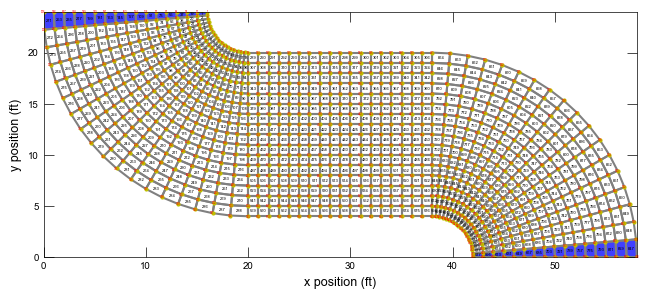

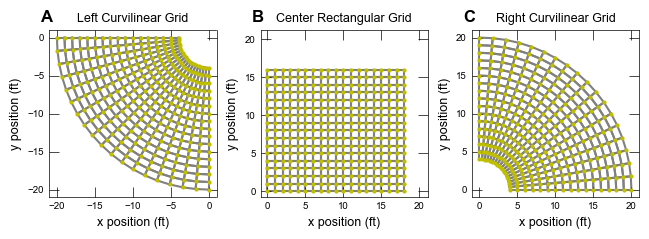

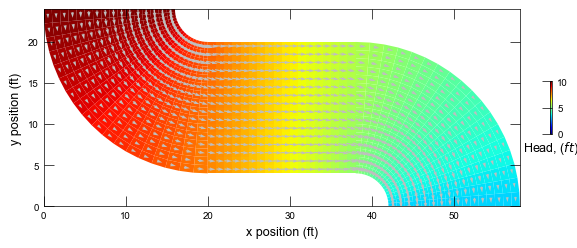

In [6]:
def scenario(silent=True):
    # key = list(parameters.keys())[idx]
    # params = parameters[key].copy()
    sim = build_models(sim_name)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)


# Run simulation
scenario()

if plot:
    # Solve analytical solution and plot results with MF6 results
    plot_results()